In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dima2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv(r"d:\dowload2\datasets_nlp\train_science.csv")
print(df.head())

       Id                                            Comment      Topic
0   0x840  A few things. You might have negative- frequen...    Biology
1   0xbf0  Is it so hard to believe that there exist part...    Physics
2  0x1dfc                                     There are bees    Biology
3   0xc7e  I'm a medication technician. And that's alot o...    Biology
4   0xbba                     Cesium is such a pretty metal.  Chemistry


In [4]:
df['Topic'].value_counts()

Topic
Biology      3591
Chemistry    2920
Physics      2184
Name: count, dtype: int64

In [6]:
df['Topic'].isnull().sum()

np.int64(0)

In [5]:
df['Comment'].str.len().describe()

count    8695.000000
mean      169.286832
std       294.992807
min         1.000000
25%        36.000000
50%        78.000000
75%       174.000000
max      7298.000000
Name: Comment, dtype: float64

In [8]:
df.duplicated(subset=['Comment']).sum()

np.int64(745)

In [11]:
# Сгруппируем по тексту и посмотрим, сколько разных меток у каждого
duplicates_with_labels = (
    df.groupby('Comment')['Topic']
      .nunique()
      .reset_index()
      .rename(columns={'Topic': 'unique_labels_count'})
)

# Оставим только те тексты, где меток больше 1 (то есть противоречия)
conflicted = duplicates_with_labels[duplicates_with_labels['unique_labels_count'] > 1]

print(f"Количество конфликтных дубликатов: {len(conflicted)}")


Количество конфликтных дубликатов: 20


In [12]:
conflicted_examples = df[df['Comment'].isin(conflicted['Comment'])] \
    .sort_values('Comment')

conflicted_examples.head(20)


,Id,Comment,Topic,n_chars,n_words
633,0x1c42,No,Chemistry,2,1
3454,0xe1b,No,Chemistry,2,1
1944,0x2731,No,Physics,2,1
5373,0xbd4,No,Chemistry,2,1
6205,0x6a5,No.,Chemistry,3,1
4345,0x14ab,No.,Physics,3,1
5103,0x79c,No.,Chemistry,3,1
3408,0x1f1b,Ok thank you,Physics,12,3
8050,0x1c18,Ok thank you,Chemistry,12,3
6163,0x2531,Ok thank you,Physics,12,3


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       8695 non-null   object
 1   Comment  8695 non-null   object
 2   Topic    8695 non-null   object
 3   n_chars  8695 non-null   int64 
 4   n_words  8695 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 339.8+ KB


In [9]:
df['n_chars'] = df['Comment'].str.len()
df['n_words'] = df['Comment'].str.split().map(len)

display(df.groupby('Topic')[['n_chars','n_words']].describe().T)


Topic              Biology    Chemistry      Physics
n_chars count  3591.000000  2920.000000  2184.000000
        mean    161.679476   157.393836   197.695971
        std     295.262206   243.605110   350.365334
        min       4.000000     1.000000     1.000000
        25%      35.000000    37.000000    36.750000
        50%      71.000000    79.000000    93.500000
        75%     150.000000   167.000000   214.000000
        max    5249.000000  2765.000000  7298.000000
n_words count  3591.000000  2920.000000  2184.000000
        mean     27.638819    27.082192    32.998626
        std      48.840005    41.428460    58.975196
        min       1.000000     1.000000     1.000000
        25%       6.000000     6.000000     6.000000
        50%      13.000000    14.000000    16.000000
        75%      25.000000    29.000000    36.000000
        max     837.000000   446.000000  1274.000000

In [15]:
# Фильтруем строки, где количество слов >= 10
new_df = df[df['Comment'].str.split().str.len() >= 10]

# Сбрасываем индексы, чтобы было аккуратно
new_df = new_df.reset_index(drop=True)


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5435 entries, 0 to 5434
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       5435 non-null   object
 1   Comment  5435 non-null   object
 2   Topic    5435 non-null   object
 3   n_chars  5435 non-null   int64 
 4   n_words  5435 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 212.4+ KB


In [17]:
new_df.duplicated(subset=['Comment']).sum()

np.int64(307)

In [18]:
# Сгруппируем по тексту и посмотрим, сколько разных меток у каждого
duplicates_with_labels = (
    new_df.groupby('Comment')['Topic']
      .nunique()
      .reset_index()
      .rename(columns={'Topic': 'unique_labels_count'})
)

# Оставим только те тексты, где меток больше 1 (то есть противоречия)
conflicted = duplicates_with_labels[duplicates_with_labels['unique_labels_count'] > 1]

print(f"Количество конфликтных дубликатов: {len(conflicted)}")


Количество конфликтных дубликатов: 0


In [19]:
new_df.describe()

,n_chars,n_words
count,5435.000000,5435.000000
mean,252.766697,43.125299
std,346.952660,57.906064
min,38.000000,10.000000
25%,85.000000,15.000000
50%,132.000000,23.000000
75%,273.000000,47.000000
max,7298.000000,1274.000000


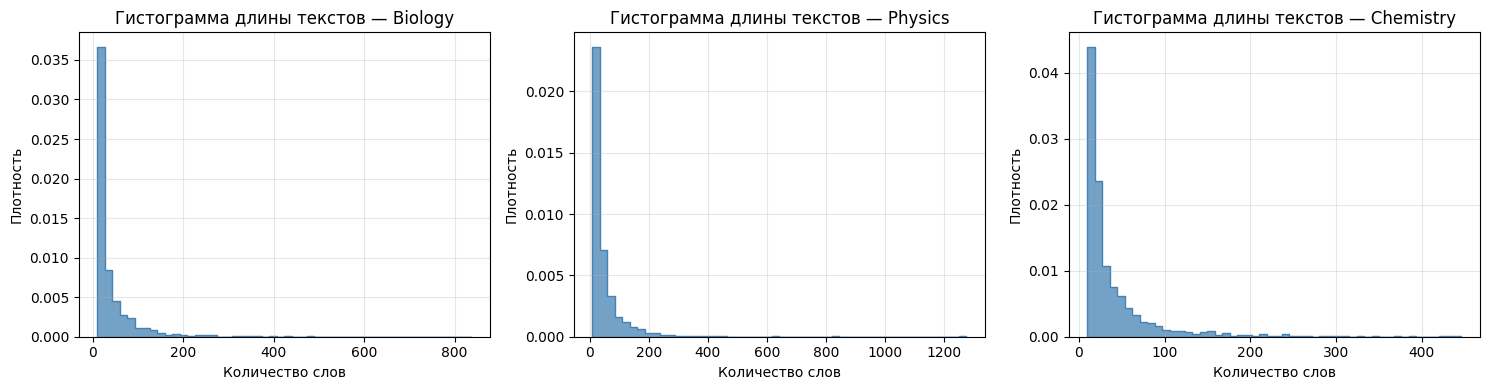

In [23]:

classes = new_df['Topic'].unique()

plt.figure(figsize=(15, 4))

for i, cls in enumerate(classes, 1):
    plt.subplot(1, 3, i)
    subset = new_df[new_df['Topic'] == cls]
    sns.histplot(subset['n_words'], bins=50, element='step', stat='density', color='steelblue')
    plt.title(f'Гистограмма длины текстов — {cls}')
    plt.xlabel('Количество слов')
    plt.ylabel('Плотность')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


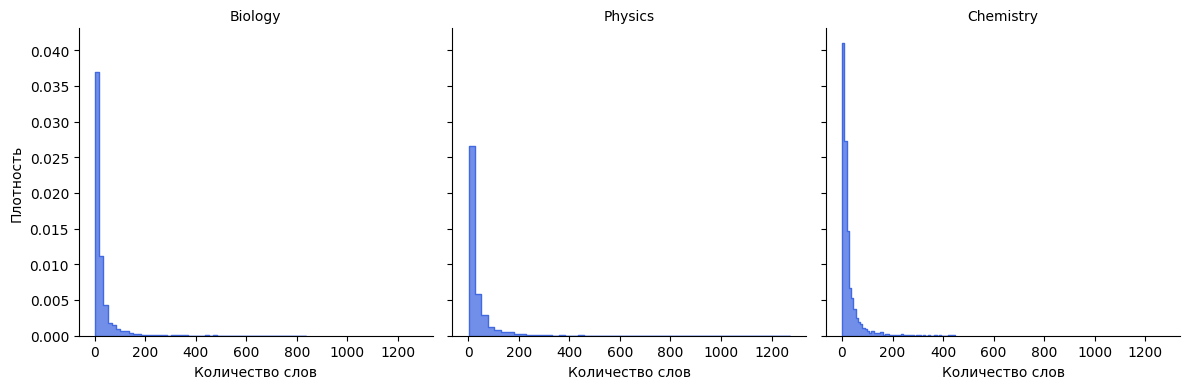

In [ ]:
#Смотрим на распределение количества слов в текстах по группам
g = sns.FacetGrid(df, col="Topic", col_wrap=3, sharex=True, sharey=True, height=4)
g.map(sns.histplot, "n_words", bins=50, element="step", stat="density", color="royalblue")
g.set_titles("{col_name}")
g.set_axis_labels("Количество слов", "Плотность")
plt.show()


In [ ]:
#Посмотрим на примеры текстов из каждой группы
for lab in df['Topic'].unique():
    print('===', lab, '===\n')
    print(new_df[new_df['Topic']==lab]['Comment'].sample(5, random_state=42).tolist())
    print('\n')


=== Biology ===

['I call them wheel bugs but they are definitely a type of assign bug like previously mentioned', 'Ok but can I drink it anyway? If it’s served cold on a hoy day I probably won’t notice… and I’ll blame the next day diarrhea on the poor choices of snacks I select after the third one…', 'I moved him so he wouldn\'t get squished...he looked at me like he was upset I would do such a thing but, his horn was never close enough to do any "Damage" to me.\\n\\nThanks for all the info!', 'If distilled water is present on both sides then “no” net osmosis occurs. If the solution is different (one side distilled/RO, another including solubles in water or non RO Water) then Osmosis occurs leaving one side with solubles (minerals, etc…) and other side with RO water. Therefore when solubles are left behind there is less water content (on the side that has not yet been filtered). In lamest terms non filtered side has less water content since it’s being cluttered with solubles (minerals

In [28]:

stop_ru = set(stopwords.words('english'))

def top_n_words(texts, n=40):
    words = []
    for t in texts:
        toks = re.findall(r'\w+', str(t).lower())
        words.extend([w for w in toks if w not in stop_ru])
    return Counter(words).most_common(n)

for lab in new_df['Topic'].unique():
    print('---', lab, '---')
    print(top_n_words(new_df[new_df['Topic']==lab]['Comment'], n=30))


--- Biology ---
[('n', 1161), ('like', 378), ('would', 359), ('one', 331), ('get', 241), ('people', 238), ('think', 211), ('know', 208), ('also', 189), ('could', 177), ('even', 169), ('body', 156), ('much', 154), ('alan', 144), ('really', 141), ('water', 141), ('need', 138), ('well', 132), ('good', 129), ('cells', 126), ('time', 123), ('see', 122), ('life', 121), ('https', 120), ('different', 116), ('way', 116), ('something', 114), ('things', 111), ('species', 108), ('first', 108)]
--- Physics ---
[('n', 1085), ('would', 367), ('time', 244), ('like', 239), ('energy', 228), ('physics', 218), ('think', 199), ('one', 189), ('light', 158), ('also', 153), ('could', 140), ('get', 138), ('see', 138), ('even', 131), ('way', 130), ('force', 130), ('know', 127), ('matter', 125), ('make', 118), ('https', 110), ('data', 107), ('1', 107), ('air', 107), ('quantum', 106), ('really', 101), ('much', 98), ('people', 97), ('good', 97), ('mass', 97), ('speed', 90)]
--- Chemistry ---
[('n', 1014), ('like',